In [1]:
include("../src/HPFEM.jl")

HPFEM

In [2]:
set_bigfloat_precision(1024)
TF = BigFloat
nel = 10
nnodes = nel + 1
idir = [1,nnodes]
M = 60
Q = M+2
b = HPFEM.ModalC01d(M, TF)
quad = HPFEM.QuadType(Q, HPFEM.GLJ, TF)
bas = HPFEM.Basis1d(b,quad, TF)
#bas = HPFEM.SEM1d(M, TF)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [3]:
π₂ = BigFloat(π)

3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724586997

In [4]:
k = 1
uexact(x) = sin(2π₂*k*x)
rhsfun(x) = sin(2π₂*k*x) * (one(TF) + (2*one(TF)π₂*k)^2)


rhsfun (generic function with 1 method)

In [5]:
a = parse(TF, "1.3")
b = parse(TF, "6.7")
nodes = [TF(x) for x in linspace(a, b, nnodes)];

In [6]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [7]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix1d, TF);

In [8]:
for e = 1:nel
    Ae = zeros(TF, M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [9]:
Fe = zeros(TF, HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
bnd = HPFEM.bndidx(lmap)
Fe[bnd[1],1] = uexact(a);
Fe[bnd[2],nel] = uexact(b);

In [10]:
HPFEM.solve!(solver, Fe);

In [11]:
nξ = 101
ξ = collect(linspace(TF(-1),TF(1),nξ));
ϕ = zeros(TF, nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

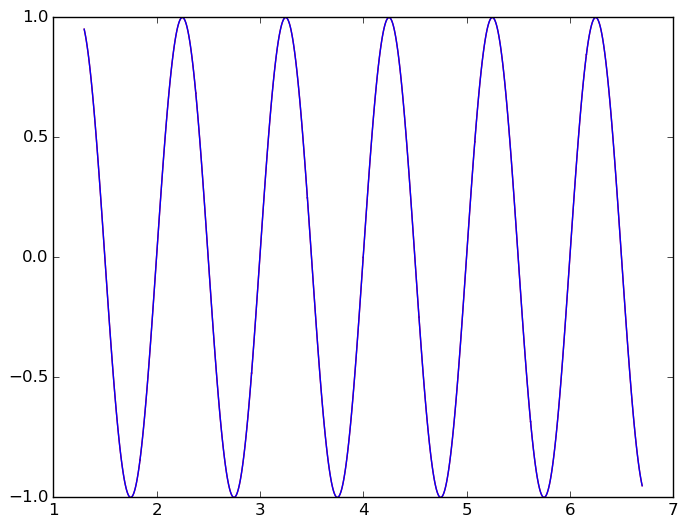

1.723556024949060302949615428418879208542139248531523227813351941720486866117053134755999350985099441515114079891284982968803398184625974885307334925965499708831084820957854406120771314848018812718258878133970088358513438174555046600064497028119812553607081843560915897113271549642220706991835564066008884295457e-86

In [12]:
using PyPlot
maxerr = zero(TF)
for e = 1:nel
    el = elems[e]
    x = (one(TF)-ξ)*el.a/2 + (one(TF)+ξ)*el.b/2 
    uu = uexact(x)
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x, Ue[:,e], "r", x, uu, "b")
end
maxerr
